In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor 
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression

In [2]:
# Load the dataset
train_df = pd.read_csv('hull-tactical-market-prediction/train.csv')
test_df = pd.read_csv('hull-tactical-market-prediction/test.csv')


## preprossing

In [3]:
def remove_nan_greater_than_threshold(df, threshold=0.5):
    """Remove columns with more than threshold proportion of NaN values."""
    return df.loc[:, df.isnull().mean() < threshold]

train_df = remove_nan_greater_than_threshold(train_df)
#train_df.info()
train_df.shape

zero_imputer = SimpleImputer(strategy='constant', fill_value=0)
zero_imputer.fit(train_df)
train_df_imputed = pd.DataFrame(zero_imputer.transform(train_df), columns=train_df.columns) # type: ignore
train_df_imputed.isnull().sum().sum()  # Should be 0 now

0

In [5]:
def categorize_features(df: pd.DataFrame) -> dict:
    """Categorize features based on their prefixes"""
    
    print("\n🏷️ FEATURE CATEGORIZATION")
    print("="*50)
    
    feature_categories = {}
    
    # Define feature categories based on prefixes
    categories = {
        'Market_Dynamics': 'M',
        'Macro_Economic': 'E',
        'Interest_Rate': 'I',
        'Price_Valuation': 'P',
        'Volatility': 'V',
        'Sentiment': 'S',
        'Momentum': 'MOM',
        'Dummy_Binary': 'D'
    }
    
    # Categorize features
    for category, prefix in categories.items():
        if prefix == 'MOM':
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix)]
        else:
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix) and not col.startswith('MOM')]
    
    # Special columns
    special_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    feature_categories['Special'] = [col for col in special_cols if col in df.columns]
    
    # Display categorization
    total_features = 0
    for category, features in feature_categories.items():
        print(f"📊 {category}: {len(features)} features")
        total_features += len(features)
    
    print(f"\n📈 Total categorized features: {total_features}")
    print(f"📈 Total columns in dataset: {df.shape[1]}")
    
    return feature_categories

feature_categories = categorize_features(train_df)
feature_categories


🏷️ FEATURE CATEGORIZATION
📊 Market_Dynamics: 14 features
📊 Macro_Economic: 19 features
📊 Interest_Rate: 9 features
📊 Price_Valuation: 13 features
📊 Volatility: 11 features
📊 Sentiment: 11 features
📊 Momentum: 0 features
📊 Dummy_Binary: 9 features
📊 Special: 4 features

📈 Total categorized features: 90
📈 Total columns in dataset: 90


{'Market_Dynamics': ['M10',
  'M11',
  'M12',
  'M15',
  'M16',
  'M17',
  'M18',
  'M2',
  'M3',
  'M4',
  'M5',
  'M7',
  'M8',
  'M9'],
 'Macro_Economic': ['E1',
  'E10',
  'E11',
  'E12',
  'E13',
  'E14',
  'E15',
  'E16',
  'E17',
  'E18',
  'E19',
  'E2',
  'E20',
  'E3',
  'E4',
  'E5',
  'E6',
  'E8',
  'E9'],
 'Interest_Rate': ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9'],
 'Price_Valuation': ['P1',
  'P10',
  'P11',
  'P12',
  'P13',
  'P2',
  'P3',
  'P4',
  'P5',
  'P6',
  'P7',
  'P8',
  'P9'],
 'Volatility': ['V1',
  'V11',
  'V12',
  'V13',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6',
  'V7',
  'V8'],
 'Sentiment': ['S1',
  'S10',
  'S11',
  'S12',
  'S2',
  'S4',
  'S5',
  'S6',
  'S7',
  'S8',
  'S9'],
 'Momentum': [],
 'Dummy_Binary': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9'],
 'Special': ['date_id',
  'forward_returns',
  'risk_free_rate',
  'market_forward_excess_returns']}

## clustering analysis


📊 MARKET SEGMENTATION ANALYSIS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 86 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M10     8990 non-null   float64
 1   M11     8990 non-null   float64
 2   M12     8990 non-null   float64
 3   M15     8990 non-null   float64
 4   M16     8990 non-null   float64
 5   M17     8990 non-null   float64
 6   M18     8990 non-null   float64
 7   M2      8990 non-null   float64
 8   M3      8990 non-null   float64
 9   M4      8990 non-null   float64
 10  M5      8990 non-null   float64
 11  M7      8990 non-null   float64
 12  M8      8990 non-null   float64
 13  M9      8990 non-null   float64
 14  E1      8990 non-null   float64
 15  E10     8990 non-null   float64
 16  E11     8990 non-null   float64
 17  E12     8990 non-null   float64
 18  E13     8990 non-null   float64
 19  E14     8990 non-null   float64
 20  E15     8990 non-null   float64
 21  E16  

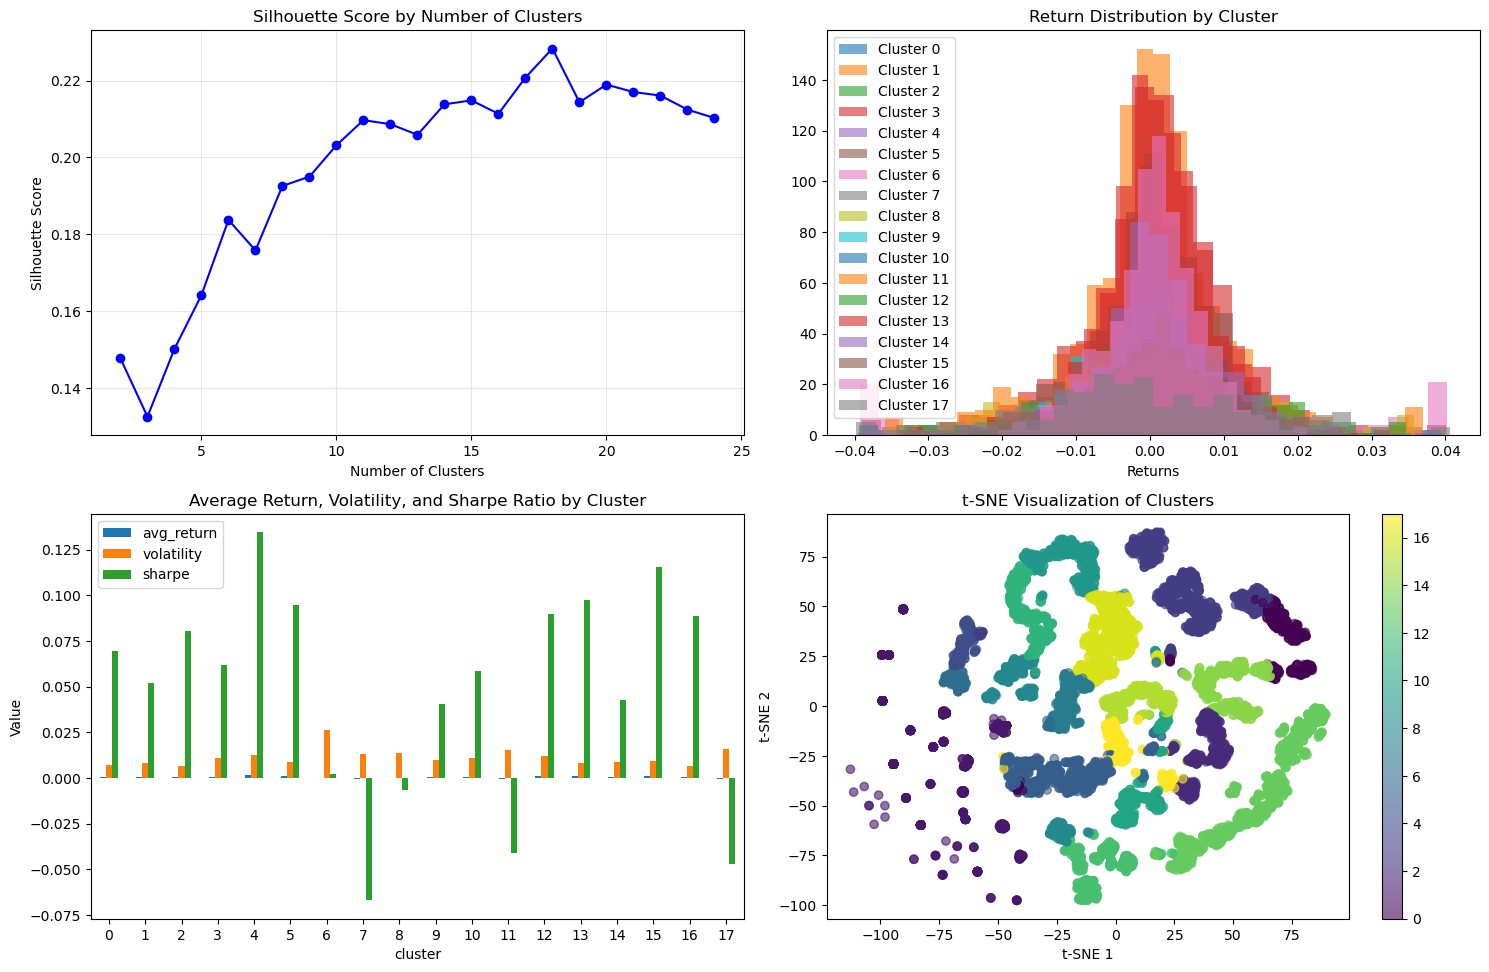

In [6]:

# 5. CLUSTERING AND SEGMENTATION ANALYSIS
def perform_market_segmentation(df, feature_categories, n_clusters=5):
    """
    Perform market regime clustering and segmentation analysis
    """
    print("\n📊 MARKET SEGMENTATION ANALYSIS")
    print("="*60)
    
    # --------------------------- data preprocessing --------------------------
    # Prepare feature matrix for clustering
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features) #[:5])  # Top 5 from each category
    
    #if len(feature_cols) > 30:
    #    feature_cols = feature_cols[:30]  # Limit features
    
    #X = df[feature_cols].fillna(0)
    X = df[feature_cols]
    print(X.info())
    #print(type(X))
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # ------------------------- clustering ---------------------------------
    # Determine optimal number of clusters
    print("🔍 DETERMINING OPTIMAL CLUSTER COUNT:")
    
    silhouette_scores = []
    k_range = range(2, min(25, len(X)//100))  # Reasonable range
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"  k={k}: Silhouette Score = {silhouette_avg:.4f}")
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters: {optimal_k}")
    
    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Analyze cluster characteristics
    print(f"\n📈 CLUSTER CHARACTERISTICS:")
    
    cluster_stats = []
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        
        if 'forward_returns' in cluster_data.columns:
            returns = cluster_data['forward_returns'].dropna()
            stats_dict = {
                'cluster': cluster_id,
                'size': len(cluster_data),
                'avg_return': returns.mean(),
                'volatility': returns.std(),
                'sharpe': returns.mean() / returns.std() if returns.std() > 0 else 0,
                'min_return': returns.min(),
                'max_return': returns.max()
            }
            cluster_stats.append(stats_dict)
            
            print(f"\nCluster {cluster_id} ({len(cluster_data)} samples):")
            print(f"  Average Return: {stats_dict['avg_return']:.6f}")
            print(f"  Volatility: {stats_dict['volatility']:.6f}")
            print(f"  Sharpe Ratio: {stats_dict['sharpe']:.4f}")
    
    cluster_stats_df = pd.DataFrame(cluster_stats)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Silhouette scores
    axes[0, 0].plot(k_range, silhouette_scores, 'bo-')
    axes[0, 0].set_title('Silhouette Score by Number of Clusters')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Cluster returns distribution
    if 'forward_returns' in df_clustered.columns:
        for cluster_id in range(optimal_k):
            cluster_returns = df_clustered[df_clustered['cluster'] == cluster_id]['forward_returns'].dropna()
            axes[0, 1].hist(cluster_returns, alpha=0.6, label=f'Cluster {cluster_id}', bins=30)
        axes[0, 1].set_title('Return Distribution by Cluster')
        axes[0, 1].set_xlabel('Returns')
        axes[0, 1].legend()
    
    # Cluster characteristics
    if cluster_stats:
        cluster_stats_df.set_index('cluster')[['avg_return', 'volatility', 'sharpe']].plot(kind='bar', ax=axes[1, 0])
        axes[1, 0].set_title('Average Return, Volatility, and Sharpe Ratio by Cluster')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].tick_params(axis='x', rotation=0)
    
    # t-SNE visualization (if computationally feasible)
    if len(X_scaled) <= 10000:  # Limit for t-SNE
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)//4))
            X_tsne = tsne.fit_transform(X_scaled)
            
            scatter = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
            axes[1, 1].set_title('t-SNE Visualization of Clusters')
            axes[1, 1].set_xlabel('t-SNE 1')
            axes[1, 1].set_ylabel('t-SNE 2')
            plt.colorbar(scatter, ax=axes[1, 1])
        except:
            axes[1, 1].text(0.5, 0.5, 't-SNE visualization\nnot available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'cluster_labels': cluster_labels,
        'cluster_stats': cluster_stats_df,
        'optimal_k': optimal_k,
        'silhouette_scores': silhouette_scores
    }
    
optimal_segmentation_results = perform_market_segmentation(train_df_imputed, feature_categories, n_clusters=5)


### result interpretation
the Silhouette Scores are noticeably better, peaking at 0.2284 (for k=18). While still in the "weak structure" category, they are much closer to the "reasonable structure" threshold of 0.25. This suggests your feature selection or preparation for this clustering run was more effective.

#### Analysis of Cluster Characteristics 📈
Your new set of 18 clusters shows a clear separation between different types of market behavior, which is exactly what you want for a predictive feature.

1. The "Bearish / Fear" Regimes 📉
You have clearly isolated several high-risk periods. A model could learn to be highly defensive when it identifies these clusters.

    Cluster 7: A strong "downturn" regime with the most negative average return (-0.000890) and significant volatility.

    Cluster 17 & 11: Also clear "risk-off" signals with strongly negative returns and high volatility.

    Cluster 6: This is a classic "high-volatility crash" regime. Its average return is near zero, but its volatility is enormous (0.026457), making it extremely risky.

    Cluster 8: A milder "drift down" market with slightly negative returns.

2. The "Strong Bullish" Regimes 🚀
You have found clusters representing periods of high growth, where an aggressive strategy would pay off.

    Cluster 4: This is your new "high-risk, high-reward" regime. It has the highest average return (0.001665) by a wide margin. Its Sharpe Ratio is also the best (0.1345).

    Cluster 12 & 15: These represent strong, positive market periods with excellent returns and good risk-adjusted performance (Sharpe Ratios of 0.0900 and 0.1156).

3. The "Stable Growth" Regimes 🌱
    These clusters represent calm, positive markets ideal for steady, low-risk investment.

    Cluster 2 & 16: These clusters have very low volatility (around 0.0066) combined with solid positive returns, leading to good Sharpe Ratios.

    Cluster 13: A large, stable cluster with good returns and a high Sharpe Ratio (0.0972).

#### Verdict and Recommendations ✅
This cluster feature is very plausible and potentially even more powerful than your last iteration due to the better statistical separation (higher Silhouette Score) and the clear identification of extreme risk/reward regimes.

Your next steps remain the same, but you can proceed with more confidence:

Test This Feature: Prioritize this new 18-cluster feature. Add it to your model and run it through your A/B testing framework to see if it improves the out-of-sample Sharpe Ratio and equity curve.

Consider Consolidation: As before, many clusters are "neutral" and similar (e.g., Clusters 0, 1, 3, 5, 9, 10, 14). If you want to create a simpler, more robust feature, you could manually group the 18 clusters into 4-6 "meta-clusters" (e.g., High_Fear, High_Reward, Stable_Growth, Neutral).

Compare Both Versions: You now have two promising cluster features (the 22-cluster version and this 18-cluster version). You can run them both through your evaluation script to see which one provides a greater performance boost to the final model.



### Cluster Assignments Over Time analysis

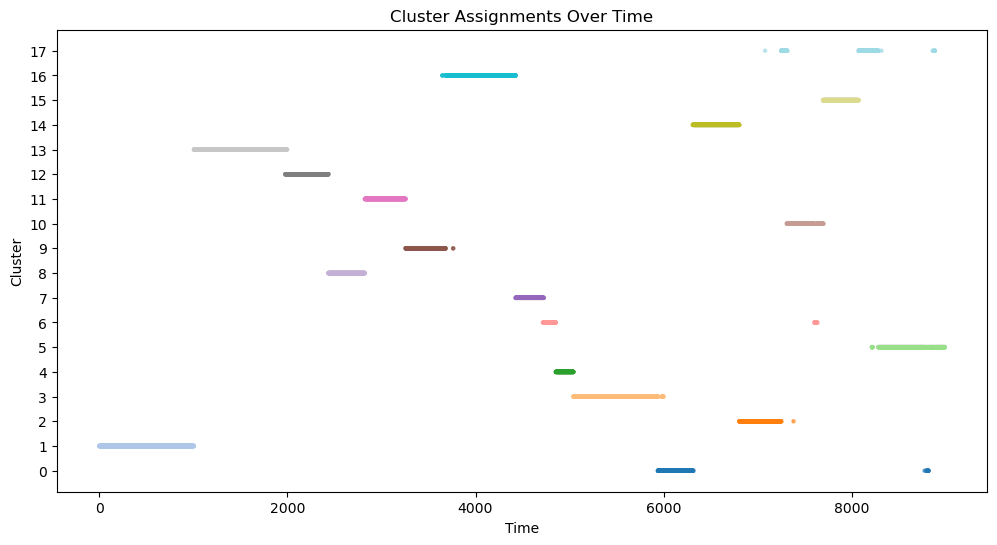

In [47]:
# visualize what clusters appear on what time
def visualize_clusters_over_time(df, segmentation_results):
    train_df_imputed_cluster = df.copy()
    train_df_imputed_cluster['cluster'] = segmentation_results['cluster_labels']
    optimal_k = segmentation_results['optimal_k']

    #print(train_df_imputed[['date_id', 'cluster']].head())

    plt.figure(figsize=(12, 6))
    plt.scatter(train_df_imputed_cluster['date_id'], train_df_imputed_cluster['cluster'], c=train_df_imputed_cluster['cluster'], cmap='tab20', alpha=0.6, s=5)
    plt.title('Cluster Assignments Over Time')
    plt.xlabel('Time')
    plt.ylabel('Cluster')
    plt.yticks(range(optimal_k))
    plt.show()

visualize_clusters_over_time(train_df_imputed, optimal_segmentation_results)

#### Results
The same cluster assignments usually land in one consecutive period over the whole time, and does not appear again.  
Based on this plot, this is not a useful clustering for a predictive model.

Your observation is exactly right and it points to a critical issue. The plot shows that your clustering algorithm has not identified recurring market regimes (like "high-volatility" or "calm growth"). Instead, it has identified distinct historical market eras or structural breaks.

1. What This Plot Reveals  
The chart shows that each cluster ID corresponds to a specific, non-repeating period of time. For example, the market is in Cluster 13 for a long stretch, then it permanently moves to Cluster 12, then to Cluster 8, and so on.  
A useful "market regime" feature would be one that the market can enter, exit, and re-enter later. For instance, a "crash" regime (let's say Cluster 7) should have appeared during the 2008 crisis and also during the 2020 COVID crash. Your plot clearly shows this is not happening.

2. The Likely Cause: Time-Trending Features  
This pattern is a classic symptom of using non-stationary or time-trending features in your clustering algorithm.  
K-Means groups data points that are "close" to each other in the feature space. If your features have a strong trend over time (e.g., they consistently increase), data points that are close in time will naturally be grouped together.  
A simple analogy is clustering people by their height from age 2 to 18. You would get clusters for "toddlers," "children," and "teenagers." A 17-year-old will never be in the "toddler" cluster because the feature (height) is strongly correlated with time (age). Your model is doing the same thing—it's clustering by "market age."

    Features that cause this include:

    - Absolute price levels of an index (e.g., the S&P 500 price).

    - Cumulative indicators or running sums.

    - Macroeconomic data that trends over decades (like GDP or national debt).

3. Why This Is a Problem for Prediction  
Your model has learned to identify eras, not states. For a predictive model, this is not useful because:  
The Future is a New Era: The model will see future data as part of the most recent era (e.g., Cluster 17 in your chart). It has no way of recognizing that a future market crash might be functionally identical to a crash from a past era (e.g., Cluster 8).  
No Recurring Patterns: The model can't learn that "when we enter Cluster X, Y tends to happen," because Cluster X only ever happened once.

4. How to Fix It: Use Stationary Features ✅  
To create a useful regime feature, you must perform clustering on features that are stationary or cyclical. These features measure relative changes, not absolute levels.  
Here are the changes you should make to the set of features you use for clustering:  
    - Use Returns, Not Prices: Instead of the S&P 500 price level, use its daily or weekly percentage change (return).
    - Use Spreads, Not Levels: For interest rates, use the spread between two rates (e.g., 10-year minus 2-year yield). Spreads tend to revert to a mean.
    - Use Oscillators: Use technical indicators that oscillate around a central line, like the RSI (Relative Strength Index) or Stochastic Oscillator.

Detrend Your Data: For any feature that still has a trend, use its first difference (today's value minus yesterday's value) or the percentage change from a long-term moving average.

#### visualize specific cluster number

In [ ]:
### visualize for specific cluster number
# 5. CLUSTERING AND SEGMENTATION ANALYSIS
def perform_market_segmentation2(df, feature_categories, n_clusters=5):
    """
    Perform market regime clustering and segmentation analysis
    """
    print("\n📊 MARKET SEGMENTATION ANALYSIS")
    print("="*60)
    
    # --------------------------- data preprocessing --------------------------
    # Prepare feature matrix for clustering
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features) #[:5])  # Top 5 from each category
    
    #if len(feature_cols) > 30:
    #    feature_cols = feature_cols[:30]  # Limit features
    
    #X = df[feature_cols].fillna(0)
    X = df[feature_cols]
    #print(X.info())
    #print(type(X))
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # ------------------------- clustering ---------------------------------
    
    optimal_k = n_clusters
    print(f"\nOptimal number of clusters: {optimal_k}")
    
    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Analyze cluster characteristics
    print(f"\n📈 CLUSTER CHARACTERISTICS:")
    
    cluster_stats = []
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        
        if 'forward_returns' in cluster_data.columns:
            returns = cluster_data['forward_returns'].dropna()
            stats_dict = {
                'cluster': cluster_id,
                'size': len(cluster_data),
                'avg_return': returns.mean(),
                'volatility': returns.std(),
                'sharpe': returns.mean() / returns.std() if returns.std() > 0 else 0,
                'min_return': returns.min(),
                'max_return': returns.max()
            }
            cluster_stats.append(stats_dict)
            
            print(f"\nCluster {cluster_id} ({len(cluster_data)} samples):")
            print(f"  Average Return: {stats_dict['avg_return']:.6f}")
            print(f"  Volatility: {stats_dict['volatility']:.6f}")
            print(f"  Sharpe Ratio: {stats_dict['sharpe']:.4f}")
    
    cluster_stats_df = pd.DataFrame(cluster_stats)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # cluster over time 
    axes[0, 0].scatter(df_clustered['date_id'], df_clustered['cluster'], c=df_clustered['cluster'], cmap='tab20', alpha=0.6, s=5)
    axes[0, 0].set_title('Cluster Assignments Over Time')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Cluster')
    axes[0, 0].set_yticks(range(optimal_k))
    
    # Cluster returns distribution
    if 'forward_returns' in df_clustered.columns:
        for cluster_id in range(optimal_k):
            cluster_returns = df_clustered[df_clustered['cluster'] == cluster_id]['forward_returns'].dropna()
            axes[0, 1].hist(cluster_returns, alpha=0.6, label=f'Cluster {cluster_id}', bins=30)
        axes[0, 1].set_title('Return Distribution by Cluster')
        axes[0, 1].set_xlabel('Returns')
        axes[0, 1].legend()
    
    
    # t-SNE visualization (if computationally feasible)
    if len(X_scaled) <= 10000:  # Limit for t-SNE
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)//4))
            X_tsne = tsne.fit_transform(X_scaled)
            
            scatter = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
            axes[1, 1].set_title('t-SNE Visualization of Clusters')
            axes[1, 1].set_xlabel('t-SNE 1')
            axes[1, 1].set_ylabel('t-SNE 2')
            plt.colorbar(scatter, ax=axes[1, 1])
        except:
            axes[1, 1].text(0.5, 0.5, 't-SNE visualization\nnot available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'cluster_labels': cluster_labels,
        'cluster_stats': cluster_stats_df,
        'optimal_k': optimal_k
    }
    
segmentation_results = perform_market_segmentation2(train_df_imputed, feature_categories, n_clusters=10)


NameError: name 'train_df_imputed' is not defined

### detrend the data


In [8]:

"""
For price-based or economic series (P*, E*): Start with differencing (.diff()) or, even better, percentage change (.pct_change()). This transforms absolute levels into relative returns, which are much more stationary.

For indicators (V*, MOM*, etc.): A powerful method you already discussed is the rolling Z-score. It detrends by subtracting the rolling mean and also standardizes by dividing by the rolling standard deviation, making it perfect for clustering algorithms.
"""

def detrend_and_standardize(df, feature_categories, window=30):
    """
    Detrend and standardize features based on their categories.
    Price/Economic series: percentage change
    Indicators: rolling Z-score
    """
    df_transformed = df.copy()
    
    for category, features in feature_categories.items():
        if category in ['Price_Valuation', 'Macro_Economic']:
            # Percentage change for price/economic series
            for feature in features:
                df_transformed[feature] = df_transformed[feature].diff().fillna(0)
        elif category not in ['Dummy_Binary', 'Special']:
            # Rolling Z-score for indicators
            for feature in features:
                rolling_mean = df_transformed[feature].rolling(window=window).mean()
                rolling_std = df_transformed[feature].rolling(window=window).std()
                #rolling_std.replace(0.0, np.nan, inplace=True)  # Avoid division by zero
                df_transformed[feature] = (df_transformed[feature] - rolling_mean) / rolling_std
                df_transformed[feature] = df_transformed[feature].fillna(0)
                
    return df_transformed

train_df_detrended = detrend_and_standardize(train_df_imputed, feature_categories, window=20)
train_df_detrended.info()
#print(train_df_detrended.columns[np.isinf(train_df_detrended).any()].tolist())  # Check for any infinite values

detrend_function_transformer = FunctionTransformer(detrend_and_standardize, kw_args={'feature_categories': feature_categories, 'window': 20})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 90 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        8990 non-null   float64
 1   D1                             8990 non-null   float64
 2   D2                             8990 non-null   float64
 3   D3                             8990 non-null   float64
 4   D4                             8990 non-null   float64
 5   D5                             8990 non-null   float64
 6   D6                             8990 non-null   float64
 7   D7                             8990 non-null   float64
 8   D8                             8990 non-null   float64
 9   D9                             8990 non-null   float64
 10  E1                             8990 non-null   float64
 11  E10                            8990 non-null   float64
 12  E11                            8990 non-null   f


📊 MARKET SEGMENTATION ANALYSIS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 86 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M10     8990 non-null   float64
 1   M11     8990 non-null   float64
 2   M12     8990 non-null   float64
 3   M15     8990 non-null   float64
 4   M16     8990 non-null   float64
 5   M17     8990 non-null   float64
 6   M18     8990 non-null   float64
 7   M2      8990 non-null   float64
 8   M3      8990 non-null   float64
 9   M4      8990 non-null   float64
 10  M5      8990 non-null   float64
 11  M7      8990 non-null   float64
 12  M8      8990 non-null   float64
 13  M9      8990 non-null   float64
 14  E1      8990 non-null   float64
 15  E10     8990 non-null   float64
 16  E11     8990 non-null   float64
 17  E12     8990 non-null   float64
 18  E13     8990 non-null   float64
 19  E14     8990 non-null   float64
 20  E15     8990 non-null   float64
 21  E16  

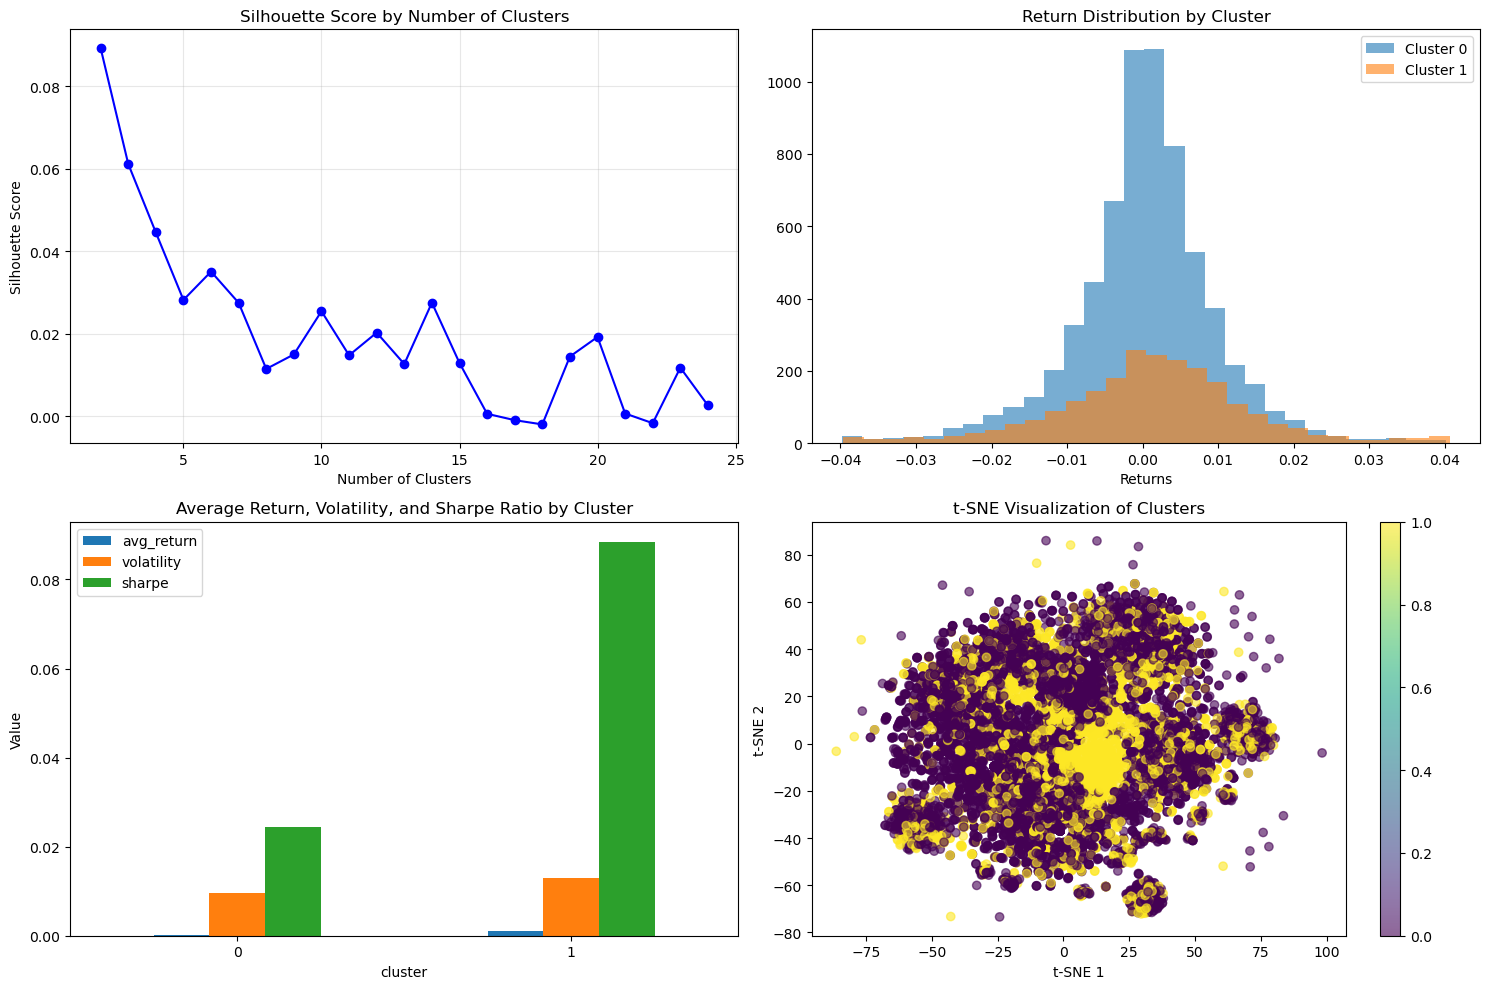

In [56]:
### do clustering again with detrended data
detrended_segmentation_results = perform_market_segmentation(train_df_detrended, feature_categories)

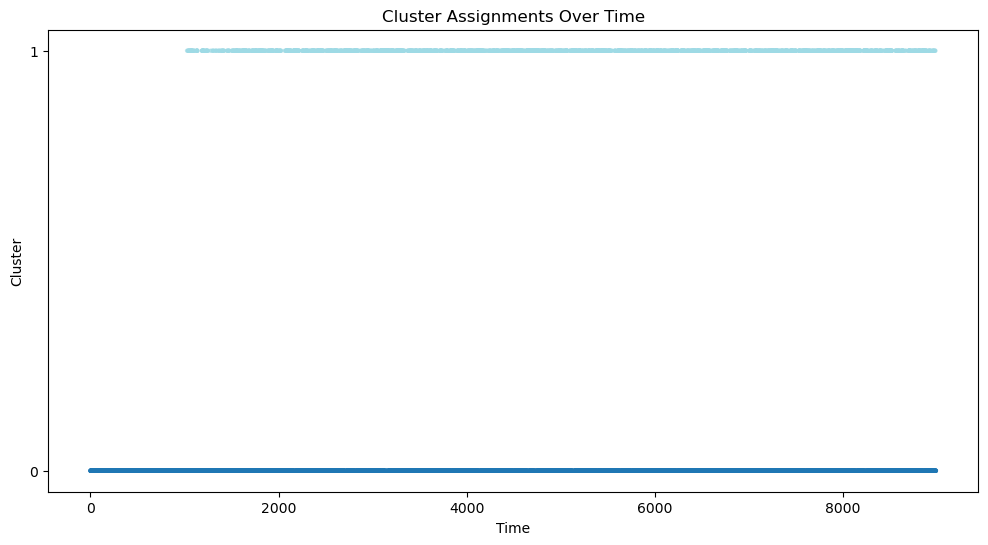

In [58]:
visualize_clusters_over_time(train_df_detrended, detrended_segmentation_results)

## Model comparison

### helper functions

In [20]:
def ad_sharpe_ratio_scorer(estimator, X, y):
    """
    一个符合 scikit-learn 接口的夏普比率评分函数。
    
    参数:
    estimator: 一个已经训练好的模型。
    X: 用于预测的特征数据。
    y: 真实的目标值 (forward returns)。
    
    返回:
    float: 策略的夏普比率。
    """
    # 1. 使用模型进行预测
    y_pred = estimator.predict(X)
    
    # 2. 将 numpy 数组转换为浮点数，避免数据类型问题
    y_pred = y_pred.astype(float)
    y_true = y.astype(float)
    
    # 3. 计算策略的每日收益
    # 策略逻辑：预测为正时买入，预测为负时不操作
    positions = np.where(y_pred > 0, y_pred, 0)
    #positions = np.clip(positions, 0, 2)
    strategy_returns = positions * y_true
    
    # 4. 计算夏普比率
    mean_return = np.mean(strategy_returns)
    std_return = np.std(strategy_returns)
    
    # 增加一个小的 epsilon 以避免除以零
    epsilon = 1e-8
    sharpe_ratio = mean_return / (std_return + epsilon)
    
    # 5. 返回夏普比率。scikit-learn 会尝试最大化这个值。
    return sharpe_ratio

In [21]:
def analyze_feature_importance(df, feature_categories, max_features=100):
    """Analyze feature importance using various methods"""
    
    print("\n⭐ FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    if 'forward_returns' not in df.columns:
        print("❌ No target variable found for feature importance analysis")
        return
    
    # Prepare data - remove non-feature columns
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features)
    
    # Limit features for computational efficiency
    if len(feature_cols) > max_features:
        feature_cols = feature_cols[:max_features]
        print(f"⚠️ Limited to first {max_features} features for computational efficiency")
    
    # Create feature matrix
    X = df[feature_cols].fillna(0)
    y = df['forward_returns'].fillna(0)
    
    # Remove rows where target is missing
    mask = ~df['forward_returns'].isna()
    X = X[mask]
    y = y[mask]
    if len(X) == 0:
        print("❌ No valid data for feature importance analysis")
        return
    
    print(f"📊 Analyzing {len(feature_cols)} features with {len(X)} samples")
    
    # 1. Correlation-based importance
    corr_importance = abs(X.corrwith(y)).sort_values(ascending=False)
    
    # 2. Mutual Information
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        mi_importance = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
    except:
        print("⚠️ Mutual information calculation failed")
        mi_importance = pd.Series(index=feature_cols)
    
    # Combine results
    importance_df = pd.DataFrame({
        'Correlation': corr_importance,
        'Mutual_Info': mi_importance
    }).fillna(0)
    
    # Create composite score
    importance_df['Composite_Score'] = (
        importance_df['Correlation'].rank(pct=True) + 
        importance_df['Mutual_Info'].rank(pct=True)
    ) / 2
    
    importance_df = importance_df.sort_values('Composite_Score', ascending=False)
    
    print("\n🏆 TOP 50 MOST IMPORTANT FEATURES:")
    display(importance_df.head(10))
    
    return importance_df

importance_results = analyze_feature_importance(train_df, feature_categories)


⭐ FEATURE IMPORTANCE ANALYSIS
📊 Analyzing 86 features with 8990 samples

🏆 TOP 50 MOST IMPORTANT FEATURES:

🏆 TOP 50 MOST IMPORTANT FEATURES:


,Correlation,Mutual_Info,Composite_Score
V13,0.060394,0.079288,0.976744
V7,0.031311,0.110157,0.965116
E19,0.023786,0.105425,0.930233
P5,0.021950,0.072408,0.889535
S5,0.038868,0.048110,0.860465
M17,0.023147,0.047550,0.796512
S8,0.008964,0.091594,0.796512
S2,0.036258,0.041243,0.784884
E11,0.029054,0.043066,0.779070
E12,0.027960,0.041620,0.761628


In [22]:
def create_drop_features2(df: pd.DataFrame) -> pd.DataFrame:
    global log2
    df_out = df.copy()
    
    I_cols = importance_results.head(70).index.tolist()
    ex_T_FEATURES = [] #['forward_returns']
    TOP_FEATURES= [] #['E19', 'M17', 'E11', 'E18', 'E12']
    SEP_cols = ['forward_returns', 'risk_free_rate', 'cluster']
    TARGET = 'market_forward_excess_returns'
    LAG_PERIODS = [1, 5, 20]
    ROLLING_WINDOWS = [5, 20, 60]
    COLS_TO_DROP =  ['date_id','forward_returns', 'risk_free_rate', 'E7', 'V10', 'S3', 'M1', 'M13','M14','M6','V9']
    columns_to_keep = [col for col in (I_cols + SEP_cols) if col in df_out.columns]
    df_out = df_out[columns_to_keep]

    
    for col in ex_T_FEATURES:
        if col in df_out.columns:
            for lag in LAG_PERIODS:
                df_out[f'{col}_lag_{lag}'] = df_out[col].shift(lag)
            for window in ROLLING_WINDOWS:
                df_out[f'{col}_roll_mean_{window}'] = df_out[col].shift(1).rolling(window=window, min_periods=1).mean()
                df_out[f'{col}_roll_std_{window}'] = df_out[col].shift(1).rolling(window=window, min_periods=1).std()
                
    for col in TOP_FEATURES:
        if col in df_out.columns:
            for lag in LAG_PERIODS:
                df_out[f'{col}_lag_{lag}'] = df_out[col].shift(lag)
            for window in ROLLING_WINDOWS:
                df_out[f'{col}_roll_mean_{window}'] = df_out[col].rolling(window=window, min_periods=1).mean()
                df_out[f'{col}_roll_std_{window}'] = df_out[col].rolling(window=window, min_periods=1).std()
                
    df_out.drop(columns = [col for col in COLS_TO_DROP if col in df_out.columns], inplace = True)
    if (log2):
        print(f"Feature X: {df_out.columns}")
        print(f"Feature Creator Output Shape: {df_out.shape}")
        log2 = False
    return df_out

feature_creator2 = FunctionTransformer(create_drop_features2, validate=False)

In [23]:
Best_parameters2 = {'iterations': 800, 
                   'learning_rate': 0.004,
                   'depth': 5, 
                   'min_data_in_leaf': 19, 
                   'l2_leaf_reg': 5.4,
                   'random_strength': 5.2, 
                   'colsample_bylevel': 0.86, 
                   'early_stopping_rounds': 50}

### cluster function for pipeline

In [ ]:

class create_cluster(BaseEstimator, TransformerMixin):
    def __init__(self, feature_categories):
        self.feature_categories = feature_categories

    def fit(self, X, y=None):
        # Prepare feature matrix for clustering
        feature_cols = []
        for category, features in self.feature_categories.items():
            if category != 'Special':
                feature_cols.extend(features) #[:5])  # Top 5 from each category
        
        self.feature_cols = feature_cols  # Store for transform
        
        X_cluster = X[feature_cols]
        
        # Fit and store the scaler
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X_cluster)
        
        silhouette_scores = []
        k_range = range(2, min(10, len(X_cluster)//100))  # Reasonable range
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X_scaled)
            silhouette_avg = silhouette_score(X_scaled, cluster_labels)
            silhouette_scores.append(silhouette_avg)
        
        self.optimal_k = k_range[np.argmax(silhouette_scores)]
        print(f"\nOptimal number of clusters: {self.optimal_k}")
        
        # Fit and store the final kmeans model
        self.kmeans = KMeans(n_clusters=self.optimal_k, random_state=42, n_init=10)
        self.kmeans.fit(X_scaled)
        return self
        
        
    def transform(self, X):
        """
        X: df
        Predict cluster labels for new data
        """
        #print(X.shape)
        X_transformed = X.copy()
        
        # Transform the new data using the fitted scaler and kmeans
        X_cluster = X[self.feature_cols]
        X_scaled = self.scaler.transform(X_cluster)
        cluster_labels = self.kmeans.predict(X_scaled)
        
        X_transformed["cluster"] = cluster_labels
        return X_transformed


### training

数据和函数已加载。
实验ID：9, 时间：2025/10/11

基础模型 (75 top features 0 imputer) 和新模型 (75 top features KNN-7 imputer) 已定义。

开始执行前向展开分析...
数据集大小: (8990, 89), 目标变量: market_forward_excess_returns
训练周期: index 0 to 4494 | 测试周期: index 4495 to 5393
 train: (4495, 89), test: (899, 89)
Feature X: Index(['V13', 'V7', 'E19', 'P5', 'S5', 'M17', 'S8', 'S2', 'E11', 'E12', 'M18',
       'E18', 'M4', 'I2', 'P8', 'E6', 'I9', 'E16', 'E9', 'I5', 'E17', 'M10',
       'M12', 'P10', 'E15', 'M8', 'V6', 'V1', 'M2', 'M5', 'I4', 'M3', 'P11',
       'E8', 'S7', 'I3', 'P7', 'S9', 'V5', 'P12', 'M11', 'E1', 'M7', 'V12',
       'D1', 'D2', 'E2', 'E20', 'E3', 'D8', 'D4', 'S6', 'S12', 'P2', 'E10',
       'E5', 'D6', 'P6', 'D5', 'V8', 'I7', 'D7', 'S1', 'S10', 'P3', 'E13',
       'V11', 'P4', 'P9', 'I1'],
      dtype='object')
Feature Creator Output Shape: (4495, 70)

Optimal number of clusters: 2
(4495, 89)

Optimal number of clusters: 2
(4495, 89)
(899, 89)
(899, 89)
训练周期: index 899 to 5393 | 测试周期: index 5394 to 6292
 train: (4495, 

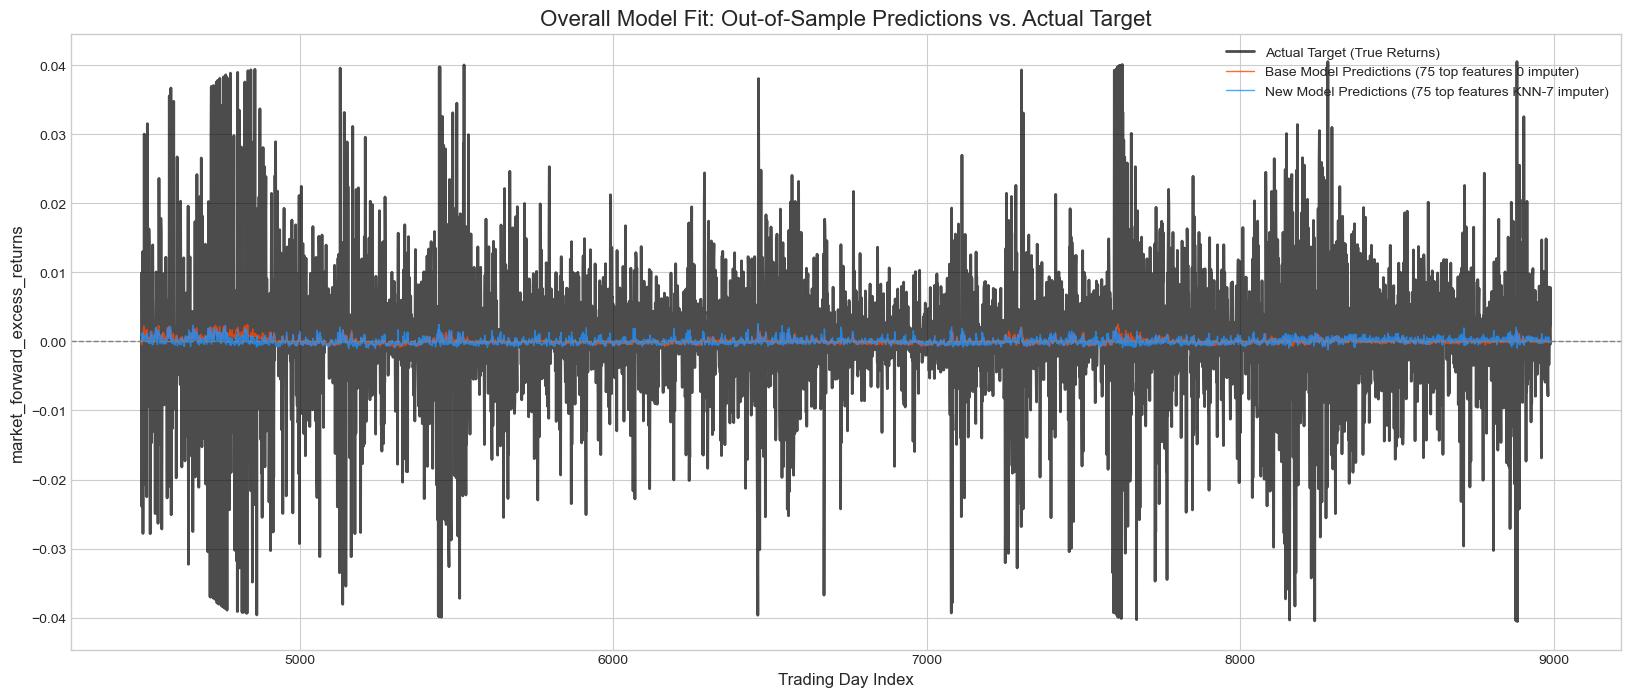


--- 正在生成累积收益拟合图 (权益曲线) ---


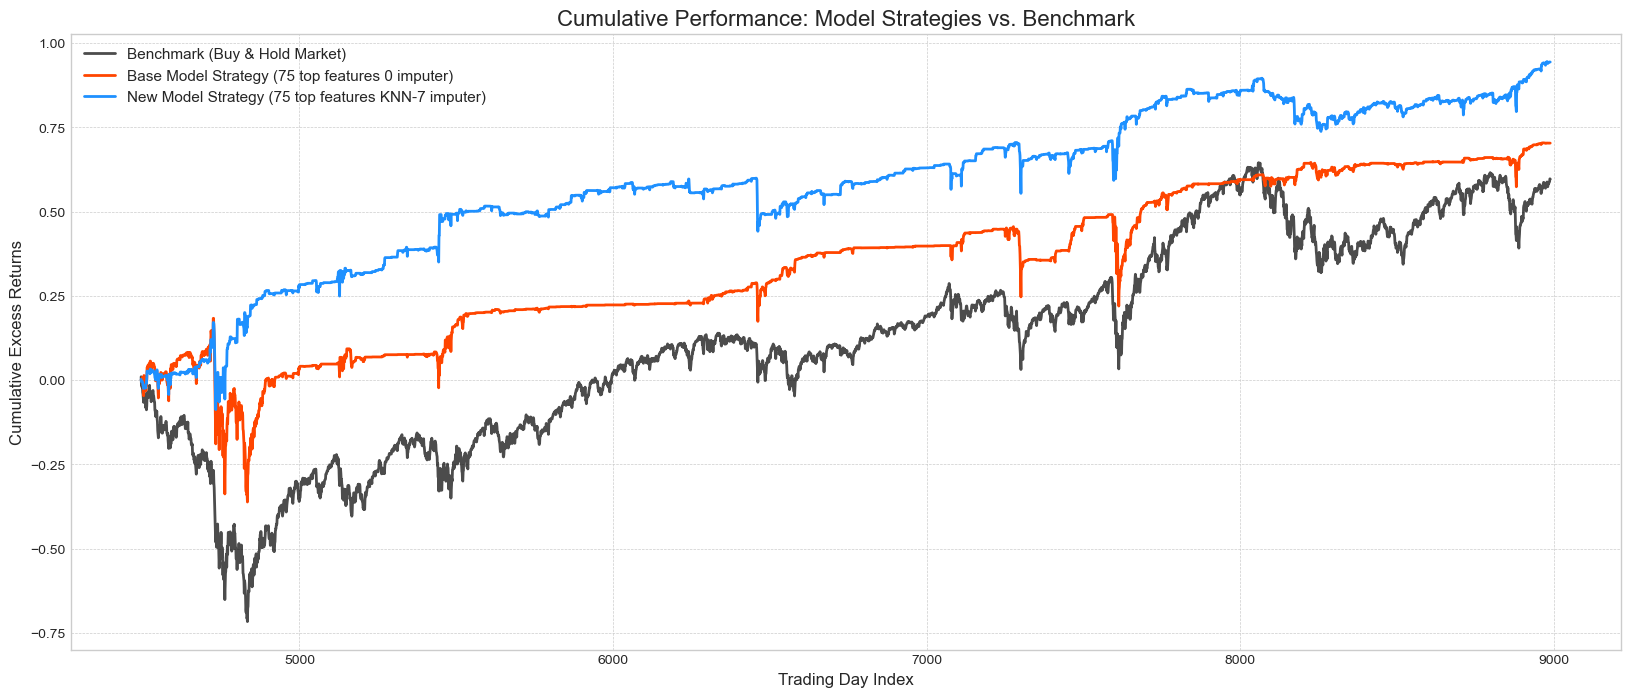

In [30]:
# --- 步骤 1 & 2: 保持不变 ---
log1 = True
log2 = True
print("数据和函数已加载。")
base_model_descirption = "75 top features 0 imputer"
new_model_descirption = "75 top features KNN-7 imputer"
ID = 9
date = "2025/10/11"

IMPUTER_PARAMETERS = {
    'n_neighbors': 7,             
    'weights': 'uniform',         # 可以是 'uniform' 或 'distance'
    'missing_values': np.nan      # 告诉 Imputer 哪些值是缺失的
}
KNN_IMPUTER = KNNImputer(**IMPUTER_PARAMETERS)

# 定义要比较的两个模型
model_base = Pipeline([
    ('feature_creator', feature_creator2),
    #('imputer', SimpleImputer(strategy='median')),
    #('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('regressor', CatBoostRegressor(**Best_parameters2, verbose=0, random_seed=42))
])
model_new = Pipeline([
    ('detrend', detrend_function_transformer),
    ('cluster', create_cluster(feature_categories = feature_categories)),
    ('feature_creator', feature_creator2),
    #('imputer', SimpleImputer(strategy='median')),
    #('knn_imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('regressor', CatBoostRegressor(**Best_parameters2, verbose=0, random_seed=42))
])
print(f"实验ID：{ID}, 时间：{date}")
print(f"\n基础模型 ({base_model_descirption}) 和新模型 ({new_model_descirption}) 已定义。")

# --- 步骤 3: 执行前向展开分析 (增加预测值收集) Rolling Forward ---

print("\n开始执行前向展开分析...")
TARGET = "market_forward_excess_returns"
FEATURES = [col for col in train_df_imputed.columns if col not in [TARGET]]
X = train_df_imputed[FEATURES]
y = train_df_imputed[TARGET]

print(f"数据集大小: {X.shape}, 目标变量: {TARGET}") # 数据集大小: (8990, 90), 目标变量: market_forward_excess_returns

n_samples = len(X)
initial_train_size = int(n_samples * 0.5)
test_size = int(n_samples * 0.1)

# 初始化列表以存储分数和预测结果
base_model_sharpe_scores, new_model_sharpe_scores = [], []
base_model_r2_scores, new_model_r2_scores = [], []
all_test_indices, all_y_true, all_base_preds, all_new_preds = [], [], [], []

train_start_index = 0
train_end_index = initial_train_size
test_end_index = train_end_index + test_size

while test_end_index <= n_samples:
    print(f"训练周期: index {train_start_index} to {train_end_index-1} | "
          f"测试周期: index {train_end_index} to {test_end_index-1}")

    X_train, y_train = X.iloc[train_start_index:train_end_index], y.iloc[train_start_index:train_end_index]
    X_test, y_test = X.iloc[train_end_index:test_end_index], y.iloc[train_end_index:test_end_index]
    
    print(f" train: {X_train.shape}, test: {X_test.shape}") #  train: (4495, 90), test: (899, 90)

    model_base.fit(X_train, y_train)
    model_new.fit(X_train, y_train)

    preds_base = model_base.predict(X_test)
    preds_new = model_new.predict(X_test)
    
    # 收集分数
    base_model_sharpe_scores.append(ad_sharpe_ratio_scorer(model_base, X_test, y_test))
    new_model_sharpe_scores.append(ad_sharpe_ratio_scorer(model_new, X_test, y_test))
    base_model_r2_scores.append(r2_score(y_test, preds_base))
    new_model_r2_scores.append(r2_score(y_test, preds_new))
    
    # <--- 新增：收集用于绘图的数据 --- >
    all_test_indices.append(y_test.index)
    all_y_true.append(y_test.values)
    all_base_preds.append(preds_base)
    all_new_preds.append(preds_new)
    
    train_start_index += test_size
    train_end_index += test_size
    test_end_index += test_size

print("\n前向展开分析完成。")
print(f"基础模型在各周期的夏普率: {[f'{s:.4f}' for s in base_model_sharpe_scores]}， 平均日夏普率：{np.mean(base_model_sharpe_scores)}")
print(f"新模型在各周期的夏普率:   {[f'{s:.4f}' for s in new_model_sharpe_scores]}， 平均日夏普率：{np.mean(new_model_sharpe_scores)}")
print("-" * 50)
print(f"基础模型在各周期的 R²: {[f'{s:.4f}' for s in base_model_r2_scores]}， 平均R2：{np.mean(base_model_r2_scores)}")
print(f"新模型在各周期的 R²:   {[f'{s:.4f}' for s in new_model_r2_scores]}， 平均R2：{np.mean(new_model_r2_scores)}")

# --- 步骤 4: t检验 (保持不变) ---
'''
print("\n--- 执行配对t检验 (基于夏普率) ---")
if len(base_model_sharpe_scores) > 2:
    t_stat_sharpe, p_val_sharpe = stats.ttest_rel(new_model_sharpe_scores, base_model_sharpe_scores, alternative='greater')
    print(f"T-statistic: {t_stat_sharpe:.4f}")
    print(f"P-value: {p_val_sharpe:.4f}")
    alpha = 0.05
    if p_val_sharpe < alpha:
        print("结论: 在夏普率方面，新模型(中位数填充)的提升在统计上是显著的。")
    else:
        print("结论: 在夏普率方面，新模型(中位数填充)的提升不具备统计显著性。")
else:
    print("测试周期太少，无法进行有效的t检验。")

# --- 4b. 针对R²的t检验 ---
print("\n--- 执行配对t检验 (基于 R²) ---")
if len(base_model_r2_scores) > 2:
    t_stat_r2, p_val_r2 = stats.ttest_rel(new_model_r2_scores, base_model_r2_scores, alternative='greater')
    print(f"T-statistic: {t_stat_r2:.4f}")
    print(f"P-value: {p_val_r2:.4f}")
    alpha = 0.05
    if p_val_r2 < alpha:
        print("结论: 在 R² 方面，新模型(中位数填充)的预测准确性提升在统计上是显著的。")
    else:
        print("结论: 在 R² 方面，新模型(中位数填充)的预测准确性提升不具备统计显著性。")
else:
    print("测试周期太少，无法进行有效的t检验。")
'''
# --- 步骤 5: 拼接数据并绘制总体拟合图 ---

print("\n--- 正在生成总体拟合图 ---")

# 1. 将所有周期的测试数据拼接成一个连续的序列
if all_test_indices:
    combined_indices = np.concatenate(all_test_indices)
    combined_y_true = pd.Series(np.concatenate(all_y_true), index=combined_indices, name="Actual Target")
    combined_base_preds = pd.Series(np.concatenate(all_base_preds), index=combined_indices, name="Base Model Preds (fill 0)")
    combined_new_preds = pd.Series(np.concatenate(all_new_preds), index=combined_indices, name="New Model Preds (median)")

    # 2. 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))

    # 3. 绘制真实值和两个模型的预测值
    plt.plot(combined_y_true, label='Actual Target (True Returns)', color='black', linewidth=2, alpha=0.7)
    plt.plot(combined_base_preds, label=f'Base Model Predictions ({base_model_descirption})', color='orangered', linewidth=1, alpha=0.8)
    plt.plot(combined_new_preds, label=f'New Model Predictions ({new_model_descirption})', color='dodgerblue', linewidth=1, alpha=0.8)

    # 4. 添加图表元素
    plt.title('Overall Model Fit: Out-of-Sample Predictions vs. Actual Target', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel(f'{TARGET}', fontsize=12)
    plt.legend(fontsize=10)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1) # 添加0线作为参考
    
    # 5. 显示图表
    plt.show()
else:
    print("没有可用于绘图的预测数据。")
    
print("\n--- 正在生成累积收益拟合图 (权益曲线) ---")

if all_test_indices:
    # 1. 拼接数据 (如果尚未拼接)
    if 'combined_y_true' not in locals():
        combined_indices = np.concatenate(all_test_indices)
        combined_y_true = pd.Series(np.concatenate(all_y_true), index=combined_indices, name="Actual Target")
        combined_base_preds = pd.Series(np.concatenate(all_base_preds), index=combined_indices, name="Base Model Preds")
        combined_new_preds = pd.Series(np.concatenate(all_new_preds), index=combined_indices, name="New Model Preds")

    # 2. 计算每个周期的策略收益
    # 基准策略: 买入并持有市场 (收益就是真实的目标值)
    benchmark_returns = combined_y_true
    
    # 基础模型策略收益 (根据 sharpe_ratio_scorer 的逻辑)
    base_positions = np.where(combined_base_preds > 0, combined_base_preds*1000, 0)
    base_positions = np.clip(base_positions, 0, 2)
    base_strategy_returns = pd.Series(base_positions*benchmark_returns.values, index=benchmark_returns.index)
    
    # 新模型策略收益
    new_positions = np.where(combined_new_preds > 0, combined_new_preds*1000, 0)
    new_positions = np.clip(new_positions, 0, 2)
    new_strategy_returns = pd.Series(new_positions*benchmark_returns.values, index=benchmark_returns.index)

    # 3. 计算累积收益 (权益曲线)
    cumulative_benchmark = benchmark_returns.cumsum()
    cumulative_base_strategy = base_strategy_returns.cumsum()
    cumulative_new_strategy = new_strategy_returns.cumsum()

    # 4. 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))

    # 5. 绘制三条累积收益曲线
    plt.plot(cumulative_benchmark, label='Benchmark (Buy & Hold Market)', color='black', linewidth=2, alpha=0.7)
    plt.plot(cumulative_base_strategy, label=f'Base Model Strategy ({base_model_descirption})', color='orangered', linewidth=2)
    plt.plot(cumulative_new_strategy, label=f'New Model Strategy ({new_model_descirption})', color='dodgerblue', linewidth=2)
    
    # 6. 添加图表元素
    plt.title('Cumulative Performance: Model Strategies vs. Benchmark', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel('Cumulative Excess Returns', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # 7. 显示图表
    plt.show()


i train the not good cluster vs base model without cluster, there are still improvements, why?

Show thinking
This is an excellent and very important question. It gets to the heart of the difference between a model finding a statistically useful pattern and a feature being robustly predictive for the future.

The short answer is that even your "not good" cluster feature is providing the model with a powerful piece of context about the market's historical era, and that context, however flawed, is slightly better than no context at all.

Let's break down the reasons why you are seeing this small improvement.

##### 1. The Main Reason: Capturing Low-Frequency "Era" Information
Even though the feature doesn't identify recurring regimes, it successfully identifies distinct eras. Think of your cluster ID as a label for the "market of the 1990s," the "market of the 2000s," and the "market of the 2010s."

These eras did, in fact, have different characteristics:

Average Volatility: The 2010s were generally less volatile than the 2000s.

Interest Rate Environment: Rates were falling for decades and then hit zero.

Market Drivers: The dot-com bubble was driven by different factors than the 2008 financial crisis.

By providing the cluster ID, you are essentially giving the model a simple, powerful piece of information: "You are currently in Era X."

The model (CatBoost) can then learn rules like:

"In Era 8, momentum features are highly predictive."

"In Era 12, valuation features don't work well, but volatility is always low."

This "era context" allows the model to weigh the other 75 features differently, leading to a slightly better fit for that specific historical data.

2. Interaction Effects
Adding any new feature, even a flawed one, changes the entire landscape for the model. It can now create new interactions. The model might discover that the combination of (Cluster_ID == 10) and (VIX > 25) is a much more powerful signal than VIX > 25 on its own. Your "era" feature is unlocking new patterns in your existing features.

3. Statistical Noise / Small Improvement
It is also important to look at the magnitude of the improvement:

Average Sharpe: 0.0276 -> 0.0285 (A very small increase)

Average R²: 0.0012 -> 0.0017 (Also very small)

Notice that in the last validation period, your new model performed significantly worse on the Sharpe Ratio (0.0152 vs. 0.0292). This suggests that the overall average improvement might not be statistically significant and could be due to the specific way the data was split in the first few folds.

##### The Crucial Warning: Why This Feature Is Still Dangerous ⚠️
Even with this small improvement, you were right to call it the "not good cluster." This feature is likely to fail in the live forecasting phase of the competition.

The problem is that it has learned to identify time, not market states. When the competition moves to future, unseen data, a new market era will begin.

The model will have no history for this new era.

If the market suddenly enters a high-volatility crash that looks a lot like the "Era 8" (e.g., the 2008 crisis), your model will not recognize it as such because the underlying trending features are at totally different levels now.

Conclusion: Your experiment is a success because it proves that providing macro-context to the model is valuable. Your next step is to provide this context using a stationary, regime-based feature (as we discussed previously). A feature that identifies recurring states like "high-volatility/bearish" will be far more robust and is much more likely to work on future data.